In [ ]:
!pip install earthengine-api

import ee
from google.colab import auth
import geemap
import time
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import cv2
import numpy as np
import os
import h5py
import tensorflow as tf
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras
import h5py
import math
import sys



ee.Authenticate()
drive.mount('/content/drive')
auth.authenticate_user()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=bgU6NVVZGxw7JFN_pttGtpqG-ii8lj1O7nbo0FiQsCI&tc=8yfm-FCHOM5Vi5oo0qXdjYgwEW7RwoeCFbFLJFSz91g&cc=efCTqPgRUT8wqlYmyKheELcgdxskS1gZ3TwOrl5iNsY

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXn1E-C7X5Elv0rlxXycnZmhUmZSWmbyIk1nfp_icMzxN2LyzUfVOok

Successfully saved authorization token.
Mounted at /content/drive


In [ ]:
#Code to get elevation at a point
def findElevation(long,lat):
  # Define the coordinate of interest (longitude, latitude)
  coordinate = ee.Geometry.Point(long, lat)

  # Use the SRTM dataset to get elevation information
  elevation = ee.Image('USGS/SRTMGL1_003').reduceRegion(
      reducer=ee.Reducer.first(),
      geometry=coordinate,
      scale=30  # Scale in meters (use 30 for SRTM1 data)
  )

  # Get the elevation value from the result
  elevation_value = elevation.get('elevation')
  print(f"Elevation : {elevation_value.getInfo()} meters")
  return elevation_value.getInfo()

print(findElevation(96.761111111,43.61277777777778))
print(findElevation(96.76083333333333,43.61277777777778))

Elevation : 1089 meters
1089
Elevation : 1089 meters
1089


In [ ]:
def createCSV():
  data = {
      'File': [],
      'Latitude': [],
      'Longitude': [],
      'Elevation in m': []
  }

  df = pd.DataFrame(data)

  # Specify the path on Google Drive where you want to save the CSV file
  drive_path = '/content/drive/My Drive/Road Safety/elevation.csv'

  # Write the DataFrame to a CSV file and save it to the specified path
  df.to_csv(drive_path, index=False)

def printToCSV(file,lat,long,elevation):
  data = {
    'File': [file],
    'Latitude': [lat],
    'Longitude': [long],
    'Elevation in m': [elevation]
  }

  df = pd.DataFrame(data)

  # Specify the path to the existing CSV file on Google Drive
  existing_drive_path = '/content/drive/My Drive/Road Safety/elevation.csv'

  # Read the existing file into a DataFrame
  existing_df = pd.read_csv(existing_drive_path)

  # Append the new data to the existing DataFrame
  updated_df = existing_df.append(df, ignore_index=True)
  # Save the updated DataFrame to the same CSV file on Google Drive
  updated_df.to_csv(existing_drive_path, index=False)

In [ ]:
# Function to calculate distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    # Create Earth Engine Point geometries
    point1 = ee.Geometry.Point(lon1, lat1)
    point2 = ee.Geometry.Point(lon2, lat2)

    # Calculate the distance (in meters)
    distance = point1.distance(point2)

    return distance.getInfo()

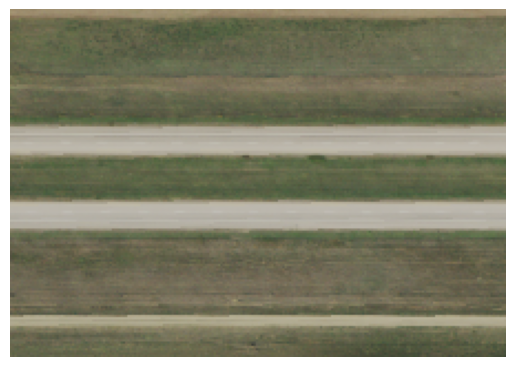

In [ ]:
def printImage(filename):
  exported_image_path = '/content/drive/MyDrive/Road Safety/naip/'+filename  # Update with your actual file path

  # Open and display the image using matplotlib
  image = Image.open(exported_image_path)

  # Display the image
  plt.imshow(image)
  plt.axis('off')  # Turn off the axis labels
  plt.show()
printImage("naip100.tif")

In [ ]:
# Load the NAIP image collection
dataset = ee.ImageCollection('USDA/NAIP/DOQQ').filterDate('2017-01-01', '2018-12-31')
trueColor = dataset.median()

trueColorVis = {
    'bands': ['R', 'G', 'B'],
    'min': 0,
    'max': 255
}


# Set the map center and add the true color image to the map
Map = geemap.Map()
Map.setCenter(-88.48, 43.069, 15)
Map.addLayer(trueColor, trueColorVis, 'True Color')

start_long = -88.4968
end_long = start_long+0.002
# last_long = -100.18
last_long = -88.476


start_lat = 43.0683
end_lat = 43.0697
i = 1

createCSV()

while start_long<last_long:

  # Define the region of interest (roi)
  roi = ee.Geometry.Rectangle([start_long, start_lat, end_long, end_lat])
  start_long += 0.0015
  end_long += 0.0015
  # Reduce the image collection to a single image by taking the mean.
  clippedImage = trueColor.visualize(**trueColorVis).clip(roi)

  filename = 'naip'+str(i)
  i += 1

  task = ee.batch.Export.image.toDrive(**{
      'image': clippedImage,
      'description': filename,
      'region': roi,
      'folder': "naip2",
      'scale': 1,  # Adjust the scale according to your needs
      'fileFormat': 'GeoTIFF',
  })

  task.start()
  while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(5)
  print(task.status())
  print(filename+" saved")
  lat = (start_lat+end_lat)/2
  long = (start_long+end_long)/2
  elevation = findElevation(long, lat)
  printToCSV(filename,lat,long,elevation)

Map

Polling for task (id: 56JFUCWRIPIEL7H4OVIXVFGP).
Polling for task (id: 56JFUCWRIPIEL7H4OVIXVFGP).
Polling for task (id: 56JFUCWRIPIEL7H4OVIXVFGP).
{'state': 'COMPLETED', 'description': 'naip1', 'creation_timestamp_ms': 1701949666337, 'update_timestamp_ms': 1701949680949, 'start_timestamp_ms': 1701949671619, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1ylyyoPKMNHCWjUBL0vZi4eg5vlpHaIMq'], 'attempt': 1, 'batch_eecu_usage_seconds': 0.48322030901908875, 'id': '56JFUCWRIPIEL7H4OVIXVFGP', 'name': 'projects/earthengine-legacy/operations/56JFUCWRIPIEL7H4OVIXVFGP'}
naip1 saved
Elevation : 271 meters
Polling for task (id: SIKLWOIRDGXB43S24ZDJWSWK).
Polling for task (id: SIKLWOIRDGXB43S24ZDJWSWK).
Polling for task (id: SIKLWOIRDGXB43S24ZDJWSWK).
Polling for task (id: SIKLWOIRDGXB43S24ZDJWSWK).
{'state': 'COMPLETED', 'description': 'naip2', 'creation_timestamp_ms': 1701949682455, 'update_timestamp_ms': 1701949698091, 'start_timestamp_ms': 1701949689046, 'tas

Map(center=[43.069, -88.48], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
#Using sentinel

# Define the cloud masking function
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

# Load the Sentinel-2 image collection
dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
                  .filterDate('2020-01-01', '2020-01-30') \
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                  .map(maskS2clouds)

# Create a Map instance using geemap
Map = geemap.Map(center=[17.7009, 83.277], zoom=12)

# Visualize the Sentinel-2 imagery on the map
vis_params = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2']
}
Map.setCenter(-100.62, 43.9087, 15)
Map.addLayer(dataset.median(), vis_params, 'Sentinel-2 Image')


start_long = -100.63
end_long = start_long+0.002
# last_long = -100.18
last_long = -100.20


start_lat = 43.908
end_lat = 43.9094
i = 1


while start_long<last_long:

  # Define the region of interest (roi)
  roi = ee.Geometry.Rectangle([start_long, start_lat, end_long, end_lat])
  start_long += 0.0015
  end_long += 0.0015

  meanImage = dataset.median().visualize(bands=['B4', 'B3', 'B2'], min=0.0, max=0.3)
  # Clip the image to the specified region.
  clippedImage = meanImage.clip(roi)
  # clippedImage = meanImage.clip(roi)

  filename = 'sentinel'+str(i)
  i += 1

  task = ee.batch.Export.image.toDrive(**{
    'image': clippedImage,
    'description': filename,
    'region': roi,
    'folder': 'sentinel',
    'scale': 1,
    'fileFormat': 'GeoTIFF',
  })

  task.start()
  while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(5)
  print(task.status())
  print(filename+" saved")

Map

Polling for task (id: Z6LJVTAOPDIASQN3OYPH7QWU).
Polling for task (id: Z6LJVTAOPDIASQN3OYPH7QWU).
Polling for task (id: Z6LJVTAOPDIASQN3OYPH7QWU).
Polling for task (id: Z6LJVTAOPDIASQN3OYPH7QWU).
{'state': 'COMPLETED', 'description': 'sentinel1', 'creation_timestamp_ms': 1699683226093, 'update_timestamp_ms': 1699683244017, 'start_timestamp_ms': 1699683236093, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1_xyDalEOS2-O9SAkfI_DDGz1Dbbv8-Cv'], 'attempt': 1, 'batch_eecu_usage_seconds': 0.2865653336048126, 'id': 'Z6LJVTAOPDIASQN3OYPH7QWU', 'name': 'projects/earthengine-legacy/operations/Z6LJVTAOPDIASQN3OYPH7QWU'}
sentinel1 saved
Polling for task (id: GGO2F7P43ONXIFYJXSASY4TX).
Polling for task (id: GGO2F7P43ONXIFYJXSASY4TX).
Polling for task (id: GGO2F7P43ONXIFYJXSASY4TX).
Polling for task (id: GGO2F7P43ONXIFYJXSASY4TX).
{'state': 'COMPLETED', 'description': 'sentinel2', 'creation_timestamp_ms': 1699683248318, 'update_timestamp_ms': 1699683265386, 'sta

KeyboardInterrupt: ignored

In [ ]:
# Define the image collection and filter by date
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2021-05-01', '2021-06-01')

# Define a function to apply scaling factors
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True) \
                .addBands(thermal_bands, None, True)

# Map the function over the image collection
dataset = dataset.map(apply_scale_factors)

# Define visualization parameters
visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

Map = geemap.Map(center=[17.7009, 83.277], zoom=12)


Map.setCenter(-100.62, 43.9087, 15)
Map.addLayer(dataset, visualization, 'True Color (432)')

start_long = -100.63
end_long = start_long+0.002
# last_long = -100.18
last_long = -100.20


start_lat = 43.0683
end_lat = 43.0697
i = 1


while start_long<last_long:

  # Define the region of interest (roi)
  roi = ee.Geometry.Rectangle([start_long, start_lat, end_long, end_lat])
  start_long += 0.0015
  end_long += 0.0015
  filename = 'lansat'+str(i)
  i+=1

  meanImage = dataset.median().visualize(bands=['SR_B4', 'SR_B3', 'SR_B2'], min=0.0, max=0.3)
  # Clip the image to the specified region.
  clippedImage = meanImage.clip(roi)

  task = ee.batch.Export.image.toDrive(**{
    'image': clippedImage,
    'description': filename,
    'region': roi,
    'folder': 'landsat',
    'scale': 1,
    'fileFormat': 'GeoTIFF',
  })


  task.start()
  while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(5)
  print(task.status())
  print(filename+" saved")
Map.addLayerControl()
Map


meanImage = dataset.median().visualize(bands=['SR_B4', 'SR_B3', 'SR_B2'], min=0.0, max=0.3)
# Clip the image to the specified region.
clippedImage = meanImage.clip(roi)

filename = "landsat"

task = ee.batch.Export.image.toDrive(**{
    'image': clippedImage,
    'description': filename,
    'region': roi,
    'folder': 'landsat',
    'scale': 1,
    'fileFormat': 'GeoTIFF',
})



Polling for task (id: WW3XWDUMNBBFHSCTSX44CQCO).
Polling for task (id: WW3XWDUMNBBFHSCTSX44CQCO).
Polling for task (id: WW3XWDUMNBBFHSCTSX44CQCO).
{'state': 'COMPLETED', 'description': 'lansat1', 'creation_timestamp_ms': 1699686868892, 'update_timestamp_ms': 1699686884580, 'start_timestamp_ms': 1699686876099, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1sOfpAzN2B1sYJEsvE3WdORGbhiVbkuWO'], 'attempt': 1, 'batch_eecu_usage_seconds': 0.4447968006134033, 'id': 'WW3XWDUMNBBFHSCTSX44CQCO', 'name': 'projects/earthengine-legacy/operations/WW3XWDUMNBBFHSCTSX44CQCO'}
lansat1 saved
Polling for task (id: AFSQNIQF5WG4T3J3QMKSIQ7D).
Polling for task (id: AFSQNIQF5WG4T3J3QMKSIQ7D).
Polling for task (id: AFSQNIQF5WG4T3J3QMKSIQ7D).
Polling for task (id: AFSQNIQF5WG4T3J3QMKSIQ7D).
{'state': 'COMPLETED', 'description': 'lansat2', 'creation_timestamp_ms': 1699686885528, 'update_timestamp_ms': 1699686902861, 'start_timestamp_ms': 1699686896093, 'task_type': 'EXPORT_I

KeyboardInterrupt: ignored

In [ ]:
#Finding the scaling factor

lat1, lon1 = 43.908, -100.64
lat2, lon2 = 43.9094, -100.64

image_path = '/content/drive/My Drive/Road Safety/naip2/naip1.tif'

image = cv2.imread(image_path)

# Get the dimensions of the image (height, width, channels)
height, width, channels = image.shape

# Calculate and print the distance
distance_result = calculate_distance(lat1, lon1, lat2, lon2)
print('Distance between points:', distance_result, 'meters')
print('Distance between points:', height, 'pixels')
print('Scale2:', height/distance_result, 'pix/meters')


Distance between points: 155.55617377230092 meters
Distance between points: 157 pixels
Scale2: 1.0092817031473948 pix/meters


In [ ]:
# Model and loss formulae Definition

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(inputs)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(pool1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(pool2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(pool3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv4)

    drop4 = Dropout(0.5)(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)

    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))

    merge6 = concatenate([drop4,up6])

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))

    merge7 = concatenate([conv3,up7])

    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)

    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)


    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))

    merge8 = concatenate([conv2,up8])

    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)

    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))

    merge9 = concatenate([conv1,up9])

    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)

    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])


    return model

In [ ]:
# Path to the folder containing images on your Google Drive
folder_path = '/content/drive/MyDrive/Road Safety/datasets/test_images'

# List the files in the folder
image_files = os.listdir(folder_path)

# Initialize an empty list to store image arrays
img_test = []
target_size = (256,256)
# Loop through each image file in the folder
for file_name in image_files:
    # Construct the full path to the image
    full_path = os.path.join(folder_path, file_name)

    # Read the image using OpenCV
    image = cv2.imread(full_path)
    # original_size = cv2.imread(full_path).shape[:2]
    # print(f"Original size of {file_name}: {original_size}")
    image = cv2.resize(image, target_size)
    # Append the image array to the list
    img_test.append(image)

# Convert the list of arrays to a NumPy array
img_test = np.array(img_test)
img_test = img_test.astype('float32')
img_test /= 255

# print(len(img_test))
# print(img_test[0].shape)

print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = unet()
print('*'*30)
print('Loading saved weights...')
print('*'*30)
model.load_weights('/content/drive/MyDrive/Road Safety/datasets/weights_bceloss_custom_dataset2100epochs.h5')

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred = model.predict(img_test, verbose=1)

******************************
Creating and compiling model...
******************************
******************************
Loading saved weights...
******************************
******************************
Predicting masks on test data...
******************************


1/1 [==============================] - 3s 3s/step


******************************
Saving predicted masks to files...
******************************


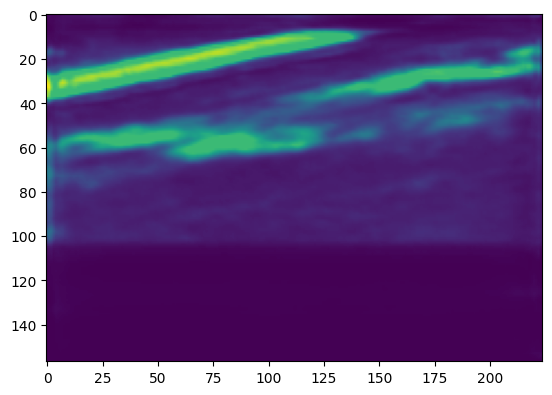

In [ ]:
#Saving Final Predictions
print('*' * 30)
print('Saving predicted masks to files...')
print('*' * 30)
pred_dir = '/content/drive/MyDrive/Road Safety/naip_test_Preds'
target_size = (224,157)
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for i, image in enumerate(mask_pred):
    image = cv2.resize(image,target_size)
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    cv2.imwrite(os.path.join(pred_dir, str(i + 1) + '_naip_pred.png'), image)

Coordinates: [(111, 95), (65, 95), (223, 93), (138, 93), (35, 93), (60, 92), (83, 90), (0, 89), (222, 86), (220, 86), (213, 76), (133, 76), (88, 76), (222, 75), (47, 75), (22, 75), (6, 75), (2, 72), (17, 62), (222, 58), (220, 58), (93, 52), (6, 48), (0, 44), (98, 41), (50, 41), (35, 41), (5, 41), (48, 27), (220, 26), (128, 26), (58, 26), (73, 24), (61, 24), (96, 23), (223, 22), (57, 22), (6, 22), (82, 21), (1, 21), (5, 18), (8, 4), (0, 0)]
Widths:  [2.0, 3.605551275463989, 4.123105625617661, 5.830951894845301, 5.0, 7.0710678118654755, 8.94427190999916, 9.055385138137417, 10.04987562112089, 9.486832980505138, 12.083045973594572, 13.92838827718412, 14.866068747318506, 15.231546211727817, 14.142135623730951, 17.72004514666935, 15.0, 21.633307652783937, 21.400934559032695, 27.073972741361768, 32.14031735997639]


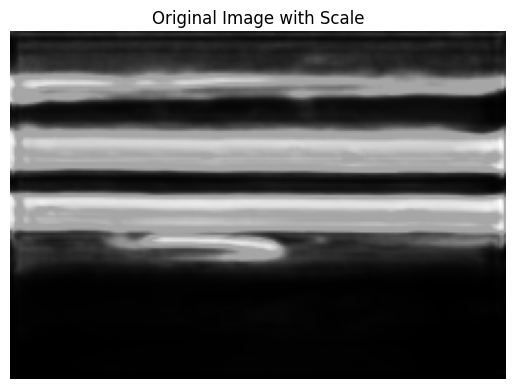

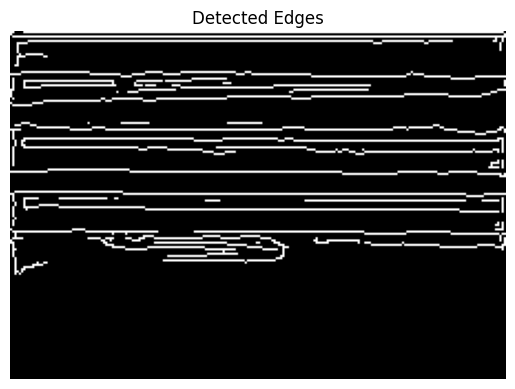

In [ ]:
# Function to display images inline in Colab
def display_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to print start and end pixels for each contour
def print_start_end_pixels(contour):
    start_pixel = tuple(contour[0][0])
    end_pixel = tuple(contour[-1][0])
    print(f"Start Pixel: {start_pixel}, End Pixel: {end_pixel}")

def findCoordinates(contours):
  coordinates = []
  for contour in contours:
    start_pixel = tuple(contour[0][0])
    coordinates.append(start_pixel)
  return coordinates

# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


# Function to find the closest distance for each coordinate
def find_closest_distances(coordinates):
    unique_distances = set()
    for i in range(len(coordinates)):
        current_point = coordinates[i]
        distance = sys.maxsize
        for j in range(len(coordinates)):
            if i != j:
                distance = min(distance,euclidean_distance(current_point, coordinates[j]))
        unique_distances.add(distance)

    closest_distances = list(unique_distances)

    return closest_distances

# Load segmentation mask
mask_path = '/content/drive/MyDrive/Road Safety/naip_test_Preds/3_naip_pred.png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Edge detection
edges = cv2.Canny(mask, 50, 150)

# Contour detection
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

coordinates = findCoordinates(contours)
print("Coordinates:",coordinates)
print("Widths: ",find_closest_distances(coordinates))


# Display the original image
display_image(mask, 'Original Image with Scale')

# Display the detected edges
display_image(edges, 'Detected Edges')
